#  Tutorial: Graph Neural Networks with Pytorch

By: [Manuel Madeira](https://manuelmlmadeira.github.io/)

Adapted from [EPFL EE-452 - Network Machine Learning](https://edu.epfl.ch/coursebook/en/network-machine-learning-EE-452)

## Instructions

We will have **coding** and **theoretical** questions. 

- Coding exercises should be solved within the specified space:
    ```python
    # Your solution here ###########################################################
    ...
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ```
    Sometimes we provide variable names, such as `x = ...`; do not change names and stick to hinted typing, as they will be reused later.

- Theoretical questions are set in markdown cells and can be identified by the following pattern:
    ```markdown
    **Your answer:**
    ...
    ```

## Objective

This tutorial focuses on Graph Neural Networks.
In the first part, you will first implement classical ML baselines and then some GNN architectures

⚠️ PyTorch/PyTorch Geometric have no CUDA support to run on Apple Silicon Macs (M1/M2/M3/M4) yet. An alternative is to install those packages from source, but given the time constraints, we recommend directly using a linux platform to run this tutorial (e.g., Google Colab). 

⚠️ Make sure that the Python version in your environment is not greater than 3.11.

Run the cell below to install the required packages.

In [1]:
%pip install -r requirements.txt
# We will need to install two additional libraries beyond the base installation of PyTorch Geometric: pyg_lib and torch-sparse. 
%pip install pyg_lib torch_sparse -f https://data.pyg.org/whl/torch-2.4.0+cu118.html

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu118.html
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Verify installation
import torch

TORCH = torch.__version__.split('+')[0]
CUDA = torch.__version__.split('+')[1]
print(f"PyTorch version: {TORCH}")
print(f"CUDA version: {CUDA}")

PyTorch version: 2.4.0
CUDA version: cu118


In [3]:
# Import necessary libraries
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_geometric as pyg
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
from torch_geometric.nn.models import GCN, GAT, GIN
from torchmetrics.classification import BinaryF1Score
from scipy import sparse
from tqdm import tqdm

import utils

## Section 0: Explore the data

In this section, we will go through the data to get a feeling of its content. We work with the [GitHub dataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.GitHub.html), from the [Multi-scale Attributed Node Embedding](https://arxiv.org/abs/1909.13021) paper. In this dataset, .

Important information about the dataset:
- Nodes represent developers on GitHub and edges are mutual follower relationships
- The node features correspond to an embedding of location, starred repositories, employer, and e-mail address information of each user.
- The node labels indicates whether it corresponds to a web or a machine learning developer.
- The full dataset contains 37 700 nodes, 578 006 edges, 128-dimensional node features and 2 classes.

In [4]:
# Set the device to GPU if available. Otherwise, use CPU.
device = "cuda" if torch.cuda.is_available() else "cpu"

# We now load the data and preprocess it. We will also create a mask that is True for the training set instances (80% of the data) and False for the test set ones.
data, train_mask = utils.fetch_and_preprocess_data()

Design matrix
Num. nodes: 37700; num features: 128
Target vector
First five elements: tensor([1, 1, 0, 1, 0])
Number of samples: 37700
Number of nodes in class 1: 27961
Edge index shape: torch.Size([2, 578006])
Edge index first 5 elements:
Training set size: 29636 (78.61%)
Test set size: 8064 (21.39%)
Ratio of class 1 in training: 74.12%


An important aspect of graph datasets in PyTorch Geometric is that they leverage the sparse of real graphs to store and operate over them in a more efficient way. 

For example, for a graph with 37 700 nodes as ours, its adjacency matrix has shape 37 700 × 37 700 matrix, which has approximately 1 421 290 000 entries. Suppose that this graph is stored with a **dense** representation with 1 bit per entry, then this would result in ~170 MB of storage space. If 8 bits (1 byte) are used per entry, then this would give us ~1.42 GB. Since PyTorch uses 64-bit floats (8 bytes) per entry, we would get more than 10 GB for this graph. This illustrates that even though many entries may be zero (meaning no edge) in this 37 700 x 37 700 matrix, a dense representation allocates space for all possible node pairs. However, in a **sparse** representation, instead of storing all possible entries, only the existing edges (nonzero entries) are stored, which can significantly reduce the required space (if you do the math it's ~2.2 MB in this example) 😄


### Task:

We define now the task we intend to solve: predict the label of unseen nodes in the social network graph. 

Note that, to define the training set, we use a masking strategy instead of directly partitioning the graph because our interpretation of the task is that we have a social network in which the training labels are accessible, while, for the test nodes, we can access their embeddings but not their labels. In practice, this simplifies the sampling strategy, in particular for network methods, as we do not have to worry about loosing structure.

Also, importantly, as the dataset is unbalanced, we will consider as a representative metric of performance the **F1 score**.

## Section 1: Machine and Deep learning baselines on graph data

We will start with classical ML baselines, to get some results to which we can compare. 

We will provide all the functions for the steps in this section as they are not the focus of this tutorial. Nevertheless, you should follow the steps below to understand to where we are heading.

### Baseline 1: Random Forest Classifier based on node features

In [5]:
x_train = data.x[train_mask].numpy()
y_train = data.y[train_mask].numpy()
x_test = data.x[~train_mask].numpy()
y_test = data.y[~train_mask].numpy()
rf_node_feats_f1 = utils.rf_train_and_test(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
print(f"Random Forest F1 score: {rf_node_feats_f1:.4f}")

Initalizing the Random Forest Classifier!
Starting training...
Training complete! Starting testing...
Testing complete!
Random Forest F1 score: 0.8080


### Baselines 2: Graph structure-based approach via Laplacian eigendecomposition

Now, let's implement a second benchmark, this time relying on some graph structural properties. 

An important concept in graph theory is the **Laplacian** of a graph. The Laplacian matrix is defined as:

$$
L = D - A
$$

where $D$ is the degree matrix (a diagonal matrix where each entry $d_{ii}$ is the degree of node $i$) and $A$ is the adjacency matrix.

We skip the details here, but the takeaway message is that the eigenvalues and eigenvectors of the Laplacian matrix are representative of the graph structure. Thus, we will use them to inform our baseline of the graph structure.

Note that this requires computing the eigen decomposition of the Laplacian matrix. This is a very expensive operation, and we will not be able to do it for our graph with 37 700 nodes - we would quickly run out of memory! (Go ahead and try if you wish 😉)

Nevertheless, the adjacency matrix (and, thus, the graph Laplacian) is mainly filled with zeros. So, we can optimize memory and running time by using a **sparse representation** as discussed above.

In [6]:
RUN_EIGENDECOMPOSITION = False  # Set to True to run the eigendecomposition of the Laplacian matrix (will take ~5-10 min). You can leave as False to skip this step and use random vectors instead.

# Eigendecomposition of the Laplacian matrix
A = sparse.coo_array(
    (
        np.ones(data.edge_index.shape[1]),
        (data.edge_index[0].numpy(), data.edge_index[1].numpy()),
    )
)
D = sparse.diags(A.sum(0))
laplacian = D - A

if RUN_EIGENDECOMPOSITION: 
    _eigvals, eigvecs = sparse.linalg.eigsh(laplacian, k=6, which="SM")
    eigvecs = eigvecs[:, 1:]
else:
    num_nodes = data.x.shape[0]
    eigvecs = np.random.rand(num_nodes, 5)

We will consider now a baseline that only considers the graph structure (only takes the eigendecomposition information into consideration).

In [7]:
# Only eigenvectors
x_train = eigvecs[train_mask]
y_train = data.y[train_mask].numpy()
x_test = eigvecs[~train_mask]
y_test = data.y[~train_mask].numpy()

rf_eigvecs_f1 = utils.rf_train_and_test(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
print(f"Random Forest with only structure F1 score: {rf_eigvecs_f1:.4f}")

Initalizing the Random Forest Classifier!
Starting training...
Training complete! Starting testing...
Testing complete!
Random Forest with only structure F1 score: 0.4351


### Baseline 3: Structure-aware baseline using node features and graph structure

Now we merge both previous approaches: we will concatenate the node features and graph Laplacian eigenvectors to 

graph structure Merging both the node features and the structure (basically, merging both previous baselines by concatenating their input features)

In [8]:
# Eigenvectors + node features
cat_feats = np.concatenate([data.x.numpy(), eigvecs], axis=1)
x_train = cat_feats[train_mask]
y_train = data.y[train_mask].numpy()
x_test = cat_feats[~train_mask]
y_test = data.y[~train_mask].numpy()
rf_cat_feats_f1 = utils.rf_train_and_test(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
print(f"Random Forest with structure and node features F1 score: {rf_cat_feats_f1:.4f}")

Initalizing the Random Forest Classifier!
Starting training...
Training complete! Starting testing...
Testing complete!
Random Forest with structure and node features F1 score: 0.8047


### Baseline 4: Deep Learning baseline - MLP

In this question, we move from classical ML to Deep Learning and, again, we start from a simple model to get a viable benchmark.

In [9]:
# Dataset objects
batch_size = 128
loader_train = DataLoader(
    TensorDataset(data.x[train_mask], data.y[train_mask]),
    batch_size=batch_size,
    shuffle=True,
)
loader_test = DataLoader(
    TensorDataset(data.x[~train_mask], data.y[~train_mask]),
    batch_size=batch_size,
    shuffle=False,
)

# Model
mlp = utils.MLP(data.x.shape[1], hidden_features=64).to(device)

# Training objects
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(mlp.parameters(), lr=0.005)
n_epochs = 10

We now proceed to training our model. We gather the losses of each batch, and plot the evolution of the training loss at the end. Finally, we compute the F1 score on the training and test set.

Epoch 1/10, Av. Training Loss: 0.3726
Epoch 2/10, Av. Training Loss: 0.3442
Epoch 3/10, Av. Training Loss: 0.3384
Epoch 4/10, Av. Training Loss: 0.3307
Epoch 5/10, Av. Training Loss: 0.3236
Epoch 6/10, Av. Training Loss: 0.3153
Epoch 7/10, Av. Training Loss: 0.3047
Epoch 8/10, Av. Training Loss: 0.2966
Epoch 9/10, Av. Training Loss: 0.2891
Epoch 10/10, Av. Training Loss: 0.2805


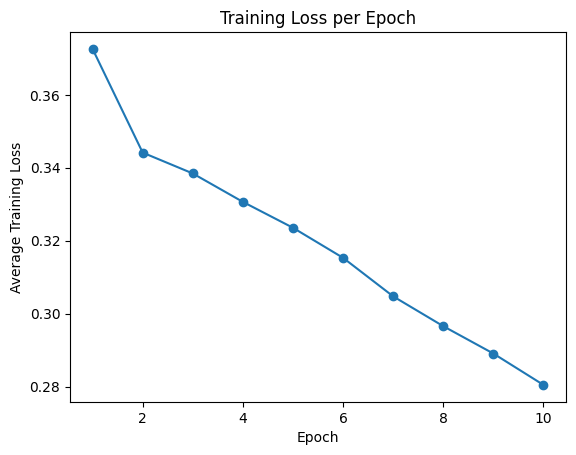

MLP F1 score in training set: 0.933
MLP F1 Score in test set:     0.901


In [10]:
train_nn = utils.train_nn(loader_train=loader_train,model=mlp,loss_fn=loss_fn,optimizer=optimizer,n_epochs=n_epochs,device=device)

# Evaluation
metric_fn = BinaryF1Score().to(device)
mlp_train_f1 = utils.eval_nn(model=mlp, loader=loader_train, metric_fn=metric_fn, device=device)
mlp_test_f1 = utils.eval_nn(model=mlp, loader=loader_test, metric_fn=metric_fn, device=device)
print(f"MLP F1 score in training set: {mlp_train_f1:.3f}")
print(f"MLP F1 Score in test set:     {mlp_test_f1:.3f}")


In [11]:
f1_scores = {
    "Random Forest w/ Node Features": rf_node_feats_f1,
    "Random Forest w/ Structure": rf_eigvecs_f1,
    "Random Forest w/ Node Features + Structure": rf_cat_feats_f1,
    "MLP w/ Node Features": mlp_test_f1,
}


def plot_f1_scores(f1_scores_dict):
    # Sort scores
    sorted_items = sorted(f1_scores_dict.items(), key=lambda x: x[1])
    models, scores = zip(*sorted_items)

    # Plot
    plt.figure(figsize=(7, 4))
    bars = plt.barh(models, scores, color='skyblue')
    plt.xlabel("F1 Score")
    plt.title("F1 Score by Model")
    plt.xlim(0, 1)

    # Add score labels to bars
    for bar in bars:
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f"{bar.get_width():.2f}", va='center')

    plt.tight_layout()
    plt.show()


Important observations:
- Including structure to classic ML approaches marginally improves the performance.
- The deep learning-based model leads to the best performance!

Can we go even further?

## Section 2: Graph Neural Networks

We now shift from the standard deep learning paradigm to Graph Neural Networks to additionally leverage the structure of our data. 

It's now your time to shine! Let's start by defining our first GNN. 

It will be a subclass of the PyTorch `Module`, but this time it will take into account the `edge_index` in its `forward method`. 
The `edge_index` consists of a 2xE matrix, where E is the number of edges in the graph. The first row contains the source nodes and the second row contains the target nodes. For undirected graphs, the edge index is symmetric, meaning that if there is an edge from node i to node j, there is also an edge from node j to node i.

Build a GCN with two layers to go from input features, here called *channels*, to a hidden dimension defined in the constructor, then to logit readout. Use ReLU activations. This GNN will map node vectors to node logits.

*Hint:* you can have a look at the GCN update rule [here](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html).

In [12]:
class MyGCN(nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int):
        super().__init__()
        # Your solution here #######################################################
        self.linear1 = nn.Linear(in_channels, hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, 1)
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    def forward(self, x, edge_index):
        # Your solution here #######################################################
        # You should convert the edge_index to an adjacency matrix A, and then compute the normalized adjacency matrix A_norm.
        num_nodes = x.size(0)
        row, col = edge_index

        # Build adjacency matrix A
        A = torch.zeros((num_nodes, num_nodes), device=x.device)
        A[row, col] = 1
        A += torch.eye(num_nodes, device=x.device)  # Add self-loops

        # Compute D^{-1/2}
        D = A.sum(dim=1)
        D_inv_sqrt = torch.diag(torch.pow(D, -0.5))

        # Compute normalized adjacency matrix
        A_norm = D_inv_sqrt @ A @ D_inv_sqrt

        # First GCN layer
        x = A_norm @ x
        x = self.linear1(x)
        x = F.relu(x)

        # Second GCN layer
        x = A_norm @ x
        x = self.linear2(x)

        return x
        # Note: it should output logits!
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Initialize a model from the class you just defined.
myGCN = MyGCN(in_channels=data.x.shape[1], hidden_channels=64).to(device)

We also instantiate a model from the built-in GCN implementation from PyTorch Geometric, so that you can have a ground truth to compare with your implementation.

In [13]:
pygGCN = GCN(in_channels=data.x.shape[1], hidden_channels=64, num_layers=2, out_channels=1).to(device)

Now write the code to perform `n_epochs` (already defined above) epochs of training with the GCN models above, using full training data as a batch. Make sure to only use training data in the loss computation by using the `train_mask`. Track the loss value at each step and plot it. Finally, evaluate the model on train and test, using the `metric_fn` from before.

In [14]:

def train_gnn_full(model, data, loss_fn, optimizer, n_epochs, device):
    loss_list = []
    # Your solution here ###########################################################
    data = data.to(device)
    for epoch in tqdm(range(n_epochs), desc="Training epochs"):
        optimizer.zero_grad()
        y_pred = model(data.x, data.edge_index).sigmoid().squeeze()
        loss = loss_fn(y_pred[train_mask], data.y[train_mask].double())
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    return loss_list


def evaluate_gnn(model, data, train_mask, metric_fn):
    # Your solution here ###########################################################
    y_pred = model(data.x, data.edge_index).squeeze()
    metric_fn.reset()
    metric_tr = metric_fn(y_pred[train_mask], data.y[train_mask])
    metric_fn.reset()
    metric_te = metric_fn(y_pred[~train_mask], data.y[~train_mask])
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    return metric_tr, metric_te



We define some helper functions to launch the training and testing process, as well as to plot the training loss against training epochs.

In [15]:
def plot_loss_list(loss_list):
    plt.plot(range(1, n_epochs + 1), loss_list, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("Training Loss per Epoch")
    plt.show()

def train_and_test_gnn(gnn_model, data, n_epochs):
    loss_fn = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(gnn_model.parameters(), lr=0.01)
    loss_list = train_gnn_full(gnn_model, data, loss_fn, optimizer, n_epochs, device)
    plot_loss_list(loss_list)
    metric_fn = BinaryF1Score().to(device)
    train_f1, test_f1 = evaluate_gnn(pygGCN, data, train_mask, metric_fn)
    print(f"{gnn_model.__class__.__name__} Training F1-score: {train_f1:.3f}")
    print(f"{gnn_model.__class__.__name__} Test F1-Score:     {test_f1:.3f}")
    return train_f1.item(), test_f1.item()


We first test the groundtruth model.

Training epochs: 100%|██████████| 10/10 [00:00<00:00, 15.51it/s]


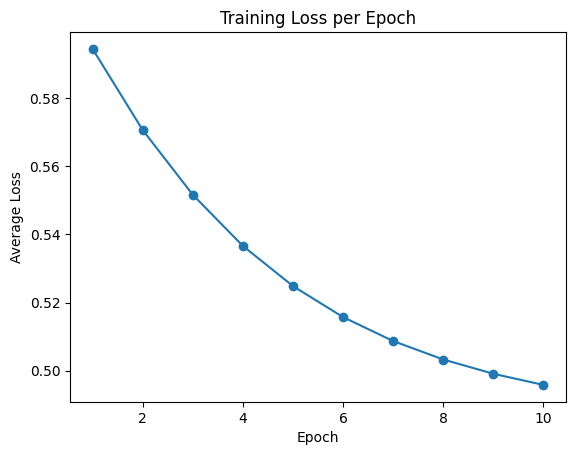

GCN Training F1-score: 0.908
GCN Test F1-Score:     0.912


In [16]:
n_epochs = 10
pyg_GCN_train_f1, pyg_GCN_test_f1 = train_and_test_gnn(pygGCN, data, n_epochs)

And now we test your implementation.

Training epochs: 100%|██████████| 10/10 [02:19<00:00, 13.99s/it]


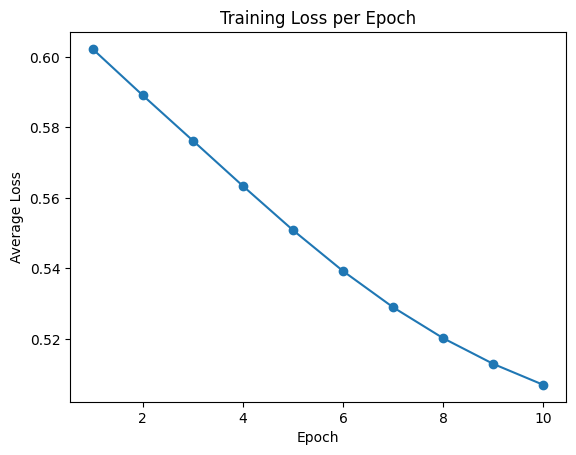

MyGCN Training F1-score: 0.908
MyGCN Test F1-Score:     0.912


In [17]:
myGCN_train_f1, myGCN_test_f1 = train_and_test_gnn(myGCN, data, n_epochs)

Did you see any difference between both implementations? If so, what do you think is the reason for that?

**Your Answer:**
Performance wise both models are similar, but the PyG implementation of the GCN is much faster than our implementation. This is because PyG uses a sparse representation of the graph, which is much more efficient than the dense representation we used in our implementation.

We got already some good results!

As you noticed, our previous implementation employed a full gradient step. However, it could be benefitial to use mini-batched training of our model for two main reasons
- GPU usage: for larger graphs, they may not fill in a single GPU;
- Stochastic optimization might yield better results.

But could we design such a setting?

Batching large graph data requires a careful approach, since on top of the design matrix with node features we have to account for edge information. In our setting, we have a single graph with many nodes, and a node level task. A batching strategy consists in sampling nodes with their neighbors, then working with this smaller graphs in a batched way. Again, PyTorch Geometric has a built-in operator for this: we define one [NeighborLoader](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader) for our data, which will gather neighbors for as many *iterations* as layers in your GCN. Check [mini batches](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html#mini-batches) if needed.

We illustrate how to proceed in this case below:

In [18]:
batch_size = 1024
loader_graph_batches = pyg.loader.NeighborLoader(
    data,
    num_neighbors=[-1] * 2,  # Use all neighbors for both layers (we could also use only a subset)
    input_nodes=train_mask,
    batch_size=batch_size,
)

def train_and_test_gnn_batched(gnn_model, batched_loader, n_epochs):
    loss_fn = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(gnn_model.parameters(), lr=0.01)
    loss_list = utils.train_gnn_batched(batched_loader, gnn_model, loss_fn, optimizer, n_epochs, device)
    plot_loss_list(loss_list)
    metric_fn = BinaryF1Score().to(device)
    train_f1, test_f1 = evaluate_gnn(pygGCN, data, train_mask, metric_fn)  # evaluation can be done on the full graph
    print(f"{gnn_model.__class__.__name__} Training F1-score: {train_f1:.3f}")
    print(f"{gnn_model.__class__.__name__} Test F1-Score:     {test_f1:.3f}")
    return train_f1.item(), test_f1.item()

Epoch 1/10: Average Loss = 0.4334
Epoch 2/10: Average Loss = 0.3420
Epoch 3/10: Average Loss = 0.3277
Epoch 4/10: Average Loss = 0.3126
Epoch 5/10: Average Loss = 0.2969
Epoch 6/10: Average Loss = 0.2830
Epoch 7/10: Average Loss = 0.2719
Epoch 8/10: Average Loss = 0.2630
Epoch 9/10: Average Loss = 0.2556
Epoch 10/10: Average Loss = 0.2499


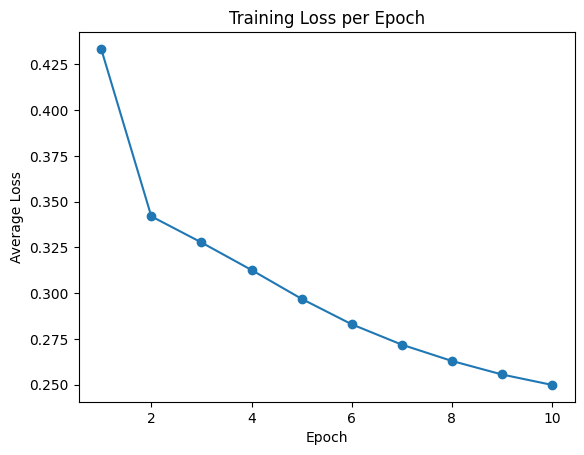

GCN Training F1-score: 0.864
GCN Test F1-Score:     0.870


In [19]:
pyg_GCN_batched_train_f1, pyg_GCN_batched_test_f1 = train_and_test_gnn_batched(
    pygGCN,
    loader_graph_batches,
    n_epochs,
)

### GNN architecures beyond GCN

In this section, we will explore some of the GNN architectures available in PyTorch Geometric. 

Check the list of models available [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#models). Pick two of them, instantiate them and observe their results.

Epoch 1/10: Average Loss = 0.3872
Epoch 2/10: Average Loss = 0.3236
Epoch 3/10: Average Loss = 0.3037
Epoch 4/10: Average Loss = 0.2853
Epoch 5/10: Average Loss = 0.2679
Epoch 6/10: Average Loss = 0.2530
Epoch 7/10: Average Loss = 0.2398
Epoch 8/10: Average Loss = 0.2281
Epoch 9/10: Average Loss = 0.2180
Epoch 10/10: Average Loss = 0.2093


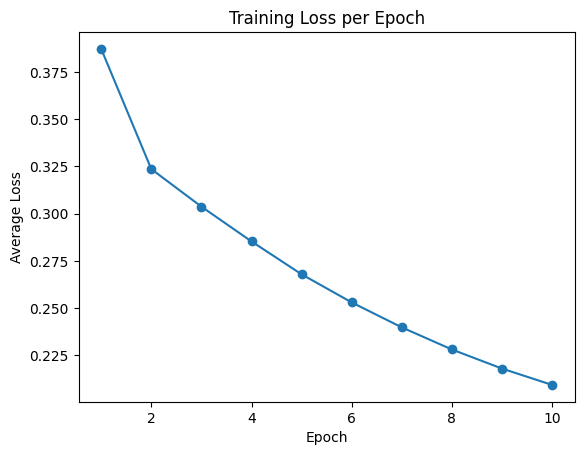

GAT Training F1-score: 0.864
GAT Test F1-Score:     0.870


In [20]:
# Model 1
# Your solution here #######################################################
pyg_gnn1 = GAT(in_channels=data.x.shape[1], hidden_channels=64, num_layers=2, out_channels=1).to(device)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
pyg_gnn1_train_f1, pyg_gnn1_test_f1 = train_and_test_gnn_batched(
    pyg_gnn1,
    loader_graph_batches,
    n_epochs,
)

Epoch 1/10: Average Loss = 0.5579
Epoch 2/10: Average Loss = 0.5563
Epoch 3/10: Average Loss = 0.5562
Epoch 4/10: Average Loss = 0.5562
Epoch 5/10: Average Loss = 0.5562
Epoch 6/10: Average Loss = 0.5562
Epoch 7/10: Average Loss = 0.5562
Epoch 8/10: Average Loss = 0.5562
Epoch 9/10: Average Loss = 0.5562
Epoch 10/10: Average Loss = 0.5562


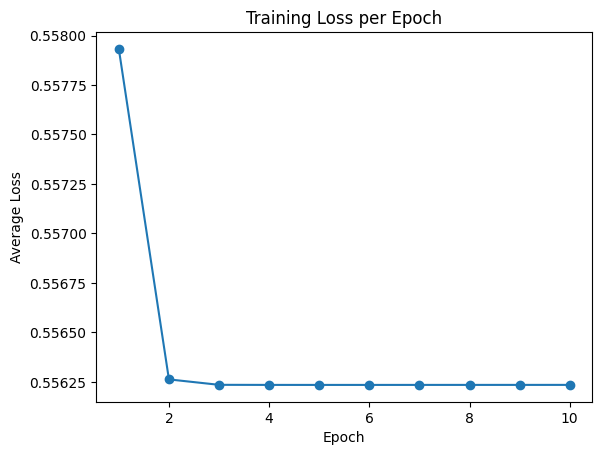

GIN Training F1-score: 0.864
GIN Test F1-Score:     0.870


In [21]:
# Model 2
# Your solution here #######################################################
pyg_gnn2 = GIN(in_channels=data.x.shape[1], hidden_channels=64, num_layers=2, out_channels=1).to(device)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
pyg_gnn2_train_f1, pyg_gnn2_test_f1 = train_and_test_gnn_batched(
    pyg_gnn2,
    loader_graph_batches,
    n_epochs,
)

## Section 3: Wrapping up

Time to compare all models we implemented so far!

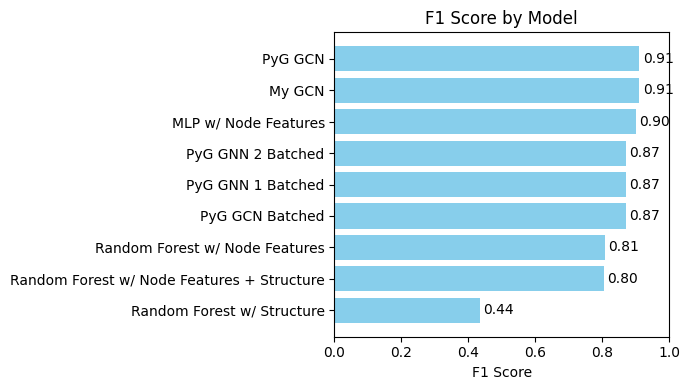

In [22]:
f1_scores["My GCN"] = myGCN_test_f1
f1_scores["PyG GCN"] = pyg_GCN_test_f1
f1_scores["PyG GCN Batched"] = pyg_GCN_batched_test_f1
f1_scores["PyG GNN 1 Batched"] = pyg_gnn1_test_f1
f1_scores["PyG GNN 2 Batched"] = pyg_gnn2_test_f1

plot_f1_scores(f1_scores)

**Your Answer:**
Dependent on architecture chosen. Importantly, we did not include any validation curve, so we cannot say if the model is overfitting or not. Please take this into consideration before taking very definitive conclusions. 🙂

### Note for the future: how to proceed in the case of small graphs?

We have demonstrated how to proceed in the case of large graphs. 

However, for many real-world applications (*e.g.* molecular graphs), the considered graphs are rather small (< 100 nodes). In these cases, we can obtain the node label predictions for nodes spanning several entire graphs in a single batch. In this case, we can use directly the `DataLoader` class from PyTorch Geometric to create mini-batches. This class takes care of batching the data for us, and it is very easy to use.

## Other Resources

In case you may want to learn more about the tools used in this tutorial, here are some links to the official documentation and tutorials:

* [PyTorch: Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html)
* [PyTorch Geometric: Official Tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html#official-examples)
